In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [78]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import json
import os
from random import shuffle
import math

import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np

# Class distribution and splitting into train/val/test

This notebook tallies the distribution of the damage and background classes.

## Look at a label JSON

Examine one JSON file in the `labels` folder...

In [5]:
label_path = './nlrc-damage-assessment/public_datasets/xBD/raw/train/labels/hurricane-matthew_00000000_post_disaster.json'

In [6]:
with open(label_path) as f:
    label_json = json.load(f)

In [8]:
label_json.keys()

dict_keys(['features', 'metadata'])

In [12]:
label_json['features'].keys()

dict_keys(['lng_lat', 'xy'])

In [9]:
label_json['metadata'].keys()

dict_keys(['sensor', 'provider_asset_type', 'gsd', 'capture_date', 'off_nadir_angle', 'pan_resolution', 'sun_azimuth', 'sun_elevation', 'target_azimuth', 'disaster', 'disaster_type', 'catalog_id', 'original_width', 'original_height', 'width', 'height', 'id', 'img_name'])

In [14]:
label_json['features']['xy'][0]

{'properties': {'feature_type': 'building',
  'subtype': 'minor-damage',
  'uid': '6dd06e25-353d-4ca2-8a93-bbdd44b10435'},
 'wkt': 'POLYGON ((184.3848180327538 1022.977380861319, 184.4809847188476 1015.871163903935, 203.263854348678 1016.01783797561, 203.5772080801356 1022.977565618902, 184.3848180327538 1022.977380861319))'}

In [15]:
feat_shape = wkt.loads(label_json['features']['xy'][0]['wkt'])

In [17]:
feat_shape.area

133.53150074518555

In [19]:
total_area = 0

for feat in label_json['features']['xy']:
    feat_shape = wkt.loads(feat['wkt'])
    total_area += feat_shape.area

total_area  # this looks about right from visualizing this tile's mask - it's < 200*200 squared pixels

25928.990821215957

## Aggregate building counts and area

Example file names
```
joplin-tornado_00000004_post_disaster.json
joplin-tornado_00000004_pre_disaster.json
```

`subtypes` are:
```
{'destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified'}
```

There are some features without a `sub-types` field. 

In [3]:
label_dirs = [
    './nlrc-damage-assessment/public_datasets/xBD/raw/train/labels',
    './nlrc-damage-assessment/public_datasets/xBD/raw/test/labels',
    './nlrc-damage-assessment/public_datasets/xBD/raw/hold/labels',
    './nlrc-damage-assessment/public_datasets/xBD/raw_tier3/labels'
]

In [4]:
# area breakdown by disaster
pre_areas = defaultdict(lambda: defaultdict(float))
post_areas = defaultdict(lambda: defaultdict(float))

# count of building features
pre_counts = defaultdict(lambda: defaultdict(int))
post_counts = defaultdict(lambda: defaultdict(int))

feature_types = set()

# building features without a subtype attribute
buildings_no_type = []

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.endswith('.json'):
            continue
            
        areas_dict = pre_areas if p.endswith('pre_disaster.json') else post_areas
        counts_dict = pre_counts if p.endswith('pre_disaster.json') else post_counts
        
        with open(os.path.join(label_dir, p)) as f:
            label_json = json.load(f)
            
            disaster_name = label_json['metadata']['disaster']
            
            for feat in label_json['features']['xy']:
                
                if feat['properties']['feature_type'] != 'building':
                    feature_types.add(feat['properties']['feature_type'])
                    continue
                
                if 'subtype' in feat['properties']:
                    damage_class = feat['properties']['subtype']
                else:
                    damage_class = 'no-subtype'  # usually for pre images
                    buildings_no_type.append((p, feat))    
                    
                feat_shape = wkt.loads(feat['wkt'])
                
                areas_dict[disaster_name][damage_class] += feat_shape.area
                
                counts_dict[disaster_name][damage_class] += 1

100%|██████████| 12738/12738 [08:19<00:00, 25.52it/s]


In [5]:
len(buildings_no_type)

425368

In [6]:
len(post_areas)

19

In [7]:
post_areas.keys()

dict_keys(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire'])

In [8]:
areas_and_counts_by_disaster = {
    'pre_areas': pre_areas,
    'post_areas': post_areas,
    'pre_counts': pre_counts,
    'post_counts': post_counts
}

In [9]:
with open('./data/areas_and_counts_by_disaster.json', 'w') as f:
    json.dump(areas_and_counts_by_disaster, f, indent=4)

In [12]:
wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']

damage_classes = ['no-damage', 'minor-damage', 'major-damage', 'destroyed', 'un-classified']

In [11]:
# store data in dic as {disaster_name: [counts]}
wind_post_counts = defaultdict(list)  
wind_post_areas = defaultdict(list) 

for disaster in wind_disasters:
    for damage_class in damage_classes:
        wind_post_counts[disaster].append(post_counts[disaster][damage_class])
        wind_post_areas[disaster].append(post_areas[disaster][damage_class])

In [12]:
post_counts['moore-tornado']

defaultdict(int,
            {'no-damage': 19453,
             'un-classified': 586,
             'destroyed': 1584,
             'minor-damage': 886,
             'major-damage': 449})

In [13]:
wind_post_counts

defaultdict(list,
            {'hurricane-matthew': [4058, 12331, 2717, 3524, 1334],
             'tuscaloosa-tornado': [10499, 2036, 466, 1097, 908],
             'hurricane-michael': [22692, 8292, 2919, 1225, 373],
             'moore-tornado': [19453, 886, 449, 1584, 586],
             'joplin-tornado': [8225, 2192, 1005, 3274, 656]})

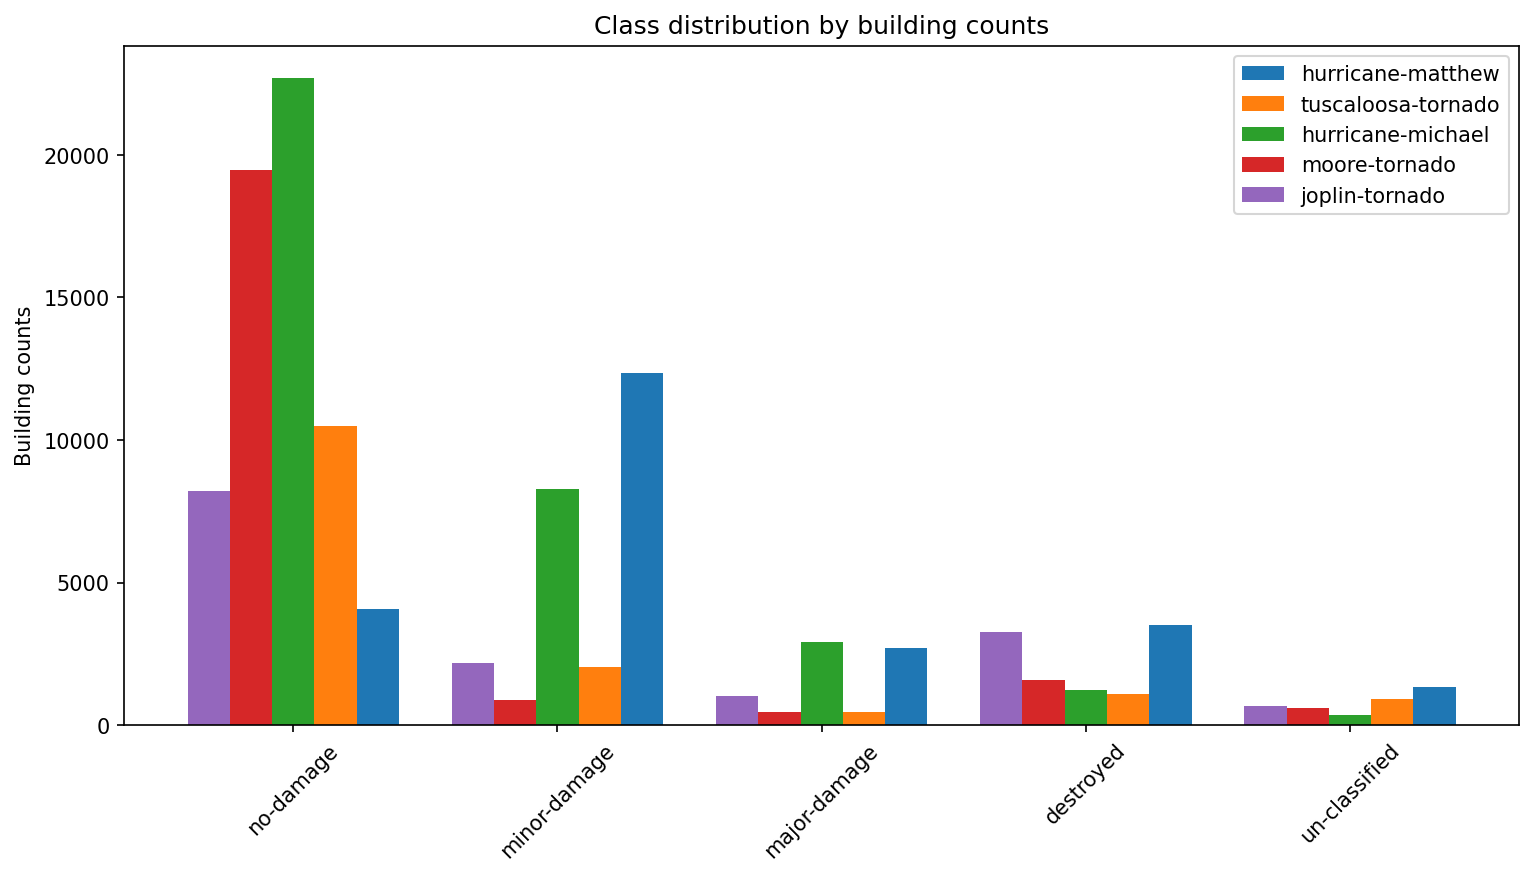

In [14]:
# Reference: https://matplotlib.org/3.3.1/gallery/lines_bars_and_markers/barchart.html
num_classes = len(damage_classes)

x = np.arange(num_classes)  # the label locations
width = 0.8/num_classes  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for i, (disaster, li) in enumerate(wind_post_counts.items()):
    rect = ax.bar(x - (i - 2) * width, li, width, label=disaster)

_ = ax.set_ylabel('Building counts')
_ = ax.set_title('Class distribution by building counts')
_ = ax.set_xticks(x)
x_labels = ax.set_xticklabels(damage_classes, rotation=45)
_ = ax.legend()

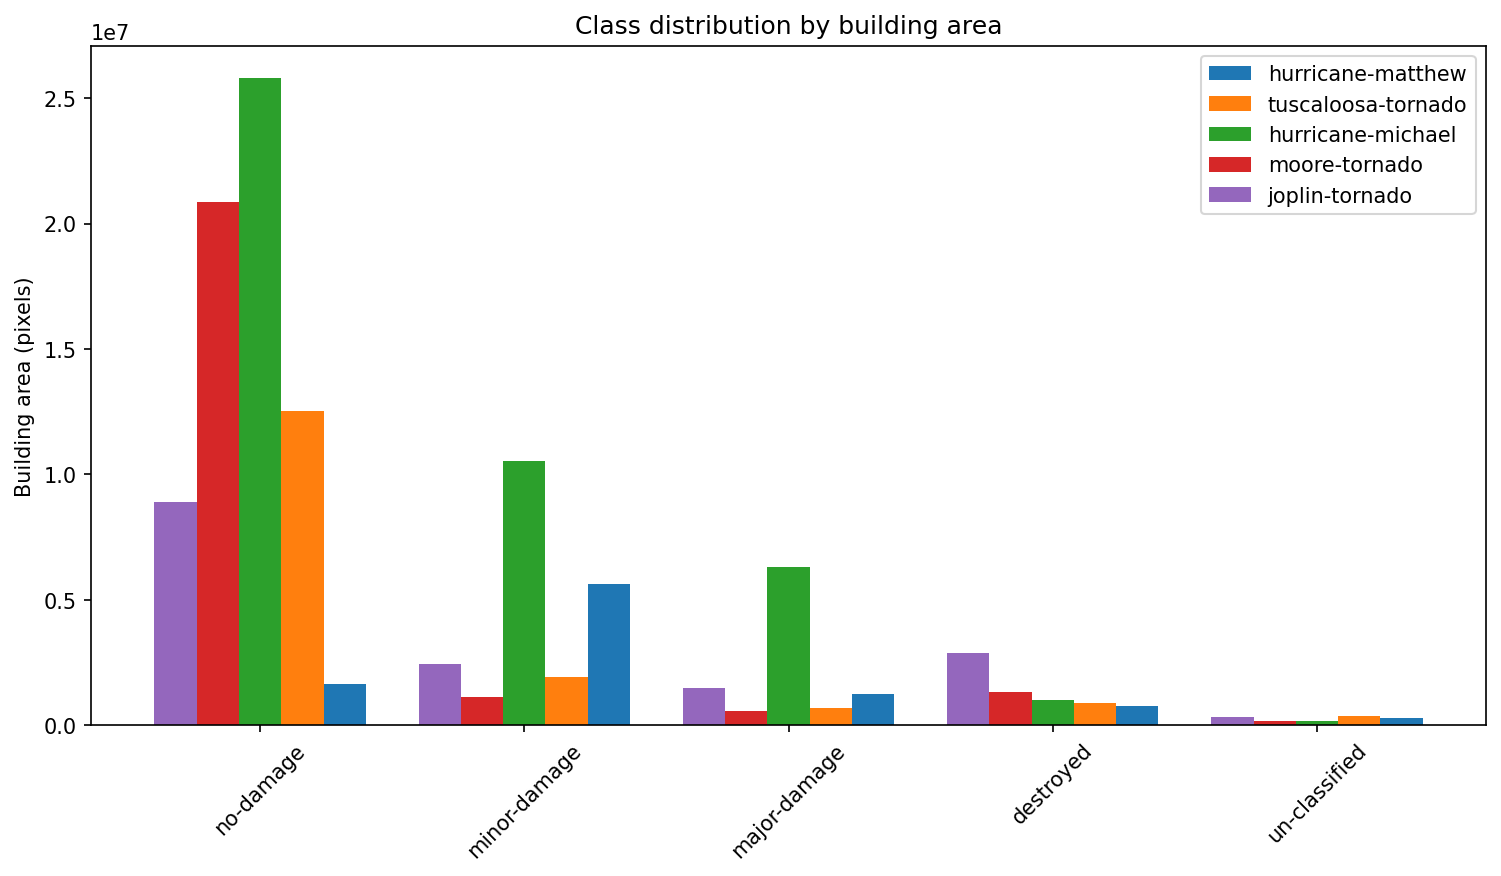

In [15]:
num_classes = len(damage_classes)

x = np.arange(num_classes)  # the label locations
width = 0.8/num_classes  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for i, (disaster, li) in enumerate(wind_post_areas.items()):
    rect = ax.bar(x - (i - 2) * width, li, width, label=disaster)

_ = ax.set_ylabel('Building area (pixels)')
_ = ax.set_title('Class distribution by building area')
_ = ax.set_xticks(x)
x_labels = ax.set_xticklabels(damage_classes, rotation=45)
_ = ax.legend()

## Splitting into train/val/test - wind disasters

We do not use the splits released by the xView2 competition.

We split at the tile level (1024 by 1024 pixels), not at the chip level. 

In [9]:
%%time

xbd_root = './xBD/'
wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']
label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw_tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

wind_disasters_tup = tuple(wind_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(wind_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 2251930.22it/s]

hurricane-michael, 550
hurricane-matthew, 405
joplin-tornado, 149
moore-tornado, 227
tuscaloosa-tornado, 343
CPU times: user 25.9 ms, sys: 0 ns, total: 25.9 ms
Wall time: 23.9 ms


In [17]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

hurricane-matthew, 405
hurricane-michael, 550
joplin-tornado, 149
moore-tornado, 227
tuscaloosa-tornado, 343


In [18]:
# split randomly

wind_splits = defaultdict(dict)  # wind disaster to train/val/test

for disaster_name, files in all_files.items():
    shuffle(files)
    
    num_train_tiles = math.ceil(0.8 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    wind_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    wind_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    wind_splits[disaster_name]['test'] = sorted(files[num_train_tiles + num_val_tiles:])
    
    print(f"{disaster_name}, train {len(wind_splits[disaster_name]['train'])}, val {len(wind_splits[disaster_name]['val'])}, test {len(wind_splits[disaster_name]['test'])}")

hurricane-matthew, train 324, val 41, test 40
hurricane-michael, train 440, val 55, test 55
joplin-tornado, train 120, val 15, test 14
moore-tornado, train 182, val 23, test 22
tuscaloosa-tornado, train 275, val 35, test 33


In [19]:
with open('./constants/splits/wind_disaster_splits.json', 'w') as f:
    json.dump(wind_splits, f, indent=4)

## Splitting into train/val/test - LOO subset disasters

In [59]:
%%time

xbd_root = './xBD/'

wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']

flood_disasters = ['midwest-flooding', 'nepal-flooding'] + ['hurricane-harvey', 'hurricane-florence']

earthquake_disasters = ['mexico-earthquake', 'palu-tsunami', 'sunda-tsunami']

others = ['guatemala-volcano', 'lower-puna-volcano', 'socal-fire', 'santa-rosa-wildfire','pinery-bushfire', 'portugal-wildfire', 'woolsey-fire']

subset_disasters = flood_disasters
label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw_tier3/labels'
]
all_files = defaultdict(list)  # subset disaster to list of files (no extension)

subset_disasters_tup = tuple(subset_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(subset_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 2341032.53it/s]

CPU times: user 21.8 ms, sys: 3.09 ms, total: 24.9 ms
Wall time: 22.7 ms


In [60]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

midwest-flooding, 445
hurricane-harvey, 522
hurricane-florence, 546
nepal-flooding, 619


In [61]:
# split leave one disaster out
disaster_to_leave_out = 'nepal-flooding' #'nepal-flooding' # 'joplin-tornado'

subset_splits = defaultdict(dict)  # subset disaster to train/val/test

for disaster_name, files in all_files.items():
    
    if disaster_name == disaster_to_leave_out:
        subset_splits[disaster_name]['train'] = []
        subset_splits[disaster_name]['val'] = []
        subset_splits[disaster_name]['test'] = files

    else:
        shuffle(files)
        num_train_tiles = math.ceil(0.8 * len(files))
        num_val_tiles = math.ceil(0.2 * len(files))
        subset_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
        subset_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
        subset_splits[disaster_name]['test'] = []
    
    print(f"{disaster_name}, train {len(wind_splits[disaster_name]['train'])}, val {len(wind_splits[disaster_name]['val'])}, test {len(wind_splits[disaster_name]['test'])}")

In [62]:
with open('./nlrc.building-damage-assessment/constants/splits_generalizability/LOO_' + disaster_to_leave_out + '_subset_disaster_splits.json', 'w') as f:
    json.dump(subset_splits, f, indent=4)

## Splitting into train/val/test - LOO all disasters

In [51]:
%%time

xbd_root = './xBD/'
all_disasters =['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire']
label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw_tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

all_disasters_tup = tuple(all_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(all_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 762339.57it/s]

CPU times: user 39.4 ms, sys: 6.25 ms, total: 45.7 ms
Wall time: 43.4 ms


In [52]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

palu-tsunami, 196
hurricane-michael, 550
midwest-flooding, 445
mexico-earthquake, 193
socal-fire, 1403
santa-rosa-wildfire, 377
hurricane-matthew, 405
hurricane-harvey, 522
guatemala-volcano, 28
hurricane-florence, 546
lower-puna-volcano, 291
nepal-flooding, 619
joplin-tornado, 149
moore-tornado, 227
pinery-bushfire, 1845
portugal-wildfire, 1869
sunda-tsunami, 148
tuscaloosa-tornado, 343
woolsey-fire, 878


In [53]:
# split leave one disaster out
disaster_to_leave_out = 'joplin-tornado' #'nepal-flooding' # 'joplin-tornado'
all_splits = defaultdict(dict)  # all disaster to train/val/test

for disaster_name, files in all_files.items():
    
    if disaster_name == disaster_to_leave_out:
        all_splits[disaster_name]['train'] = []
        all_splits[disaster_name]['val'] = []
        all_splits[disaster_name]['test'] = files

    else:
        shuffle(files)
        num_train_tiles = math.ceil(0.8 * len(files))
        num_val_tiles = math.ceil(0.2 * len(files))
        all_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
        all_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
        all_splits[disaster_name]['test'] = []
    
    print(f"{disaster_name}, train {len(all_splits[disaster_name]['train'])}, val {len(all_splits[disaster_name]['val'])}, test {len(all_splits[disaster_name]['test'])}")

In [54]:
with open('./nlrc.building-damage-assessment/constants/splits_generalizability/LOO_' + disaster_to_leave_out + '_all_disaster_splits.json', 'w') as f:
    json.dump(all_splits, f, indent=4)

## Splittnig into train/val/test - all disasters (SG: final model deliverable 90%/10%/0%)

In [74]:
%%time

xbd_root = './xBD/'
all_disasters =['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire']
label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw_tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

all_disasters_tup = tuple(all_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(all_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 794017.33it/s]

CPU times: user 44.3 ms, sys: 3.24 ms, total: 47.6 ms
Wall time: 50.4 ms


In [75]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

palu-tsunami, 196
hurricane-michael, 550
midwest-flooding, 445
mexico-earthquake, 193
socal-fire, 1403
santa-rosa-wildfire, 377
hurricane-matthew, 405
hurricane-harvey, 522
guatemala-volcano, 28
hurricane-florence, 546
lower-puna-volcano, 291
nepal-flooding, 619
joplin-tornado, 149
moore-tornado, 227
pinery-bushfire, 1845
portugal-wildfire, 1869
sunda-tsunami, 148
tuscaloosa-tornado, 343
woolsey-fire, 878


In [76]:
other_splits = defaultdict(dict)  # disasters other than the wind disasters to train/val/test

for disaster_name, files in all_files.items():

    
    shuffle(files)
    
    num_train_tiles = math.ceil(0.9 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    other_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    other_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    
    print(f"{disaster_name}, train {len(other_splits[disaster_name]['train'])}, val {len(other_splits[disaster_name]['val'])}")

palu-tsunami, train 177, val 19
hurricane-michael, train 495, val 55
midwest-flooding, train 401, val 44
mexico-earthquake, train 174, val 19
socal-fire, train 1263, val 140
santa-rosa-wildfire, train 340, val 37
hurricane-matthew, train 365, val 40
hurricane-harvey, train 470, val 52
guatemala-volcano, train 26, val 2
hurricane-florence, train 492, val 54
lower-puna-volcano, train 262, val 29
nepal-flooding, train 558, val 61
joplin-tornado, train 135, val 14
moore-tornado, train 205, val 22
pinery-bushfire, train 1661, val 184
portugal-wildfire, train 1683, val 186
sunda-tsunami, train 134, val 14
tuscaloosa-tornado, train 309, val 34
woolsey-fire, train 791, val 87


In [77]:
with open('./nlrc.building-damage-assessment/constants/splits/final_mdl_all_disaster_splits.json', 'w') as f:
    json.dump(other_splits, f, indent=4)

## Splitting into train/val/test - all disasters (initial experiments with model 80%/10%/10%)

Including the rest of the disasters, but consistent with the above wind disasters splits.

In [12]:
# listing blobs using the blob SDK instead of mounting it

import sas_blob_utils  # https://github.com/microsoft/ai4eutils/blob/master/sas_blob_utils.py

ModuleNotFoundError: No module named 'sas_blob_utils'

In [3]:
container_uri = 'https://researchlabwusstorage.blob.core.windows.net/nlrc-damage-assessment?SAS_KEY'

In [5]:
list_label_jsons = sas_blob_utils.list_blobs_in_container(
    container_uri=container_uri,
    blob_prefix='public_datasets/xBD/raw',  # includes raw/ and raw_tier3/
    blob_suffix='_post_disaster.json'
)  

0it [00:00, ?it/s]

listing blobs...


60170it [01:09, 863.02it/s]

Enumerated 11034 matching blobs out of 60170 total


In [6]:
list_label_jsons[100]

'public_datasets/xBD/raw/hold/labels/hurricane-florence_00000429_post_disaster.json'

In [9]:
disaster_to_li = defaultdict(list)

for full_path in list_label_jsons:
    rel_path = full_path.split('public_datasets/xBD/')[1]
    tile_name = rel_path.split('_post_disaster.json')[0]
    basename = os.path.basename(rel_path)
    disaster_name = basename.split('_')[0]
    disaster_to_li[disaster_name].append(tile_name)

In [10]:
disaster_to_li.keys()

dict_keys(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire'])

In [11]:
disaster_to_li['pinery-bushfire'][100]

'raw_tier3/labels/pinery-bushfire_00000100'

In [14]:
other_splits = defaultdict(dict)  # disasters other than the wind disasters to train/val/test

for disaster_name, files in disaster_to_li.items():
    
    if disaster_name in wind_disasters:
        continue
    
    shuffle(files)
    
    num_train_tiles = math.ceil(0.8 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    other_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    other_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    other_splits[disaster_name]['test'] = sorted(files[num_train_tiles + num_val_tiles:])
    
    print(f"{disaster_name}, train {len(other_splits[disaster_name]['train'])}, val {len(other_splits[disaster_name]['val'])}, test {len(other_splits[disaster_name]['test'])}")

guatemala-volcano, train 23, val 3, test 2
hurricane-florence, train 437, val 55, test 54
hurricane-harvey, train 418, val 53, test 51
mexico-earthquake, train 155, val 20, test 18
midwest-flooding, train 356, val 45, test 44
palu-tsunami, train 157, val 20, test 19
santa-rosa-wildfire, train 302, val 38, test 37
socal-fire, train 1123, val 141, test 139
lower-puna-volcano, train 233, val 30, test 28
nepal-flooding, train 496, val 62, test 61
pinery-bushfire, train 1476, val 185, test 184
portugal-wildfire, train 1496, val 187, test 186
sunda-tsunami, train 119, val 15, test 14
woolsey-fire, train 703, val 88, test 87


In [17]:
len(other_splits)

14

In [15]:
with open('../constants/splits/wind_disaster_splits.json') as f:
    wind_splits = json.load(f)

In [16]:
wind_splits.keys()

dict_keys(['hurricane-matthew', 'hurricane-michael', 'joplin-tornado', 'moore-tornado', 'tuscaloosa-tornado'])

In [18]:
for disaster_name, splits in wind_splits.items():
    other_splits[disaster_name] = splits

In [19]:
len(other_splits)

19

In [20]:
with open('../constants/splits/all_disaster_splits.json', 'w') as f:
    json.dump(other_splits, f, indent=4)